In [1]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 22.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import optuna
from optuna.samplers import TPESampler
import pickle
import warnings
from google.colab import files

warnings.filterwarnings('ignore')

In [3]:
FEATURE_COLS = [
    'Electrical speed [rad/s]',
    'I_M_a', 'I_M_b', 'I_M_c',
    'I_P_a', 'I_P_b', 'I_P_c',
    'I_B_a', 'I_B_b', 'I_B_c',
    'V_M_a', 'V_M_b', 'V_M_c',
    'V_P_a', 'V_P_b', 'V_P_c',
    'V_B_a', 'V_B_b', 'V_B_c'
]
LABEL_COL = 'Class label'

def optimize_svm(X, y, n_trials=50, name=""):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    def objective(trial):
        C = trial.suggest_float('C', 1e-1, 1e4, log=True)
        gamma = trial.suggest_float('gamma', 1e-4, 1e1, log=True)
        svc = SVC(C=C, gamma=gamma, kernel='rbf', class_weight='balanced')
        return cross_val_score(svc, X, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    C_opt = study.best_params['C']
    gamma_opt = study.best_params['gamma']
    print(f"  Best: C={C_opt:.4f}, gamma={gamma_opt:.6f}, CV={study.best_value:.4f}")
    return C_opt, gamma_opt

In [4]:
uploaded = files.upload()
file1 = list(uploaded.keys())[0]
df1 = pd.read_csv(file1)
X_all = df1[FEATURE_COLS].values
y_all = df1[LABEL_COL].values
for c in sorted(np.unique(y_all)):
    print(f"  Class {c:2d} : {np.sum(y_all == c):4d} samples")

Saving data_exp8.csv to data_exp8.csv
  Class  1 :   45 samples
  Class  2 :  446 samples
  Class  3 :  450 samples
  Class  4 :  455 samples
  Class  5 :  450 samples
  Class  6 :  450 samples
  Class  7 :  450 samples
  Class  8 :  450 samples
  Class  9 :  450 samples
  Class 10 :  450 samples
  Class 11 :  450 samples
  Class 12 :  450 samples
  Class 13 :  450 samples
  Class 14 :  450 samples
  Class 15 :  450 samples
  Class 16 :  450 samples


In [5]:
KNOWN_CLASSES = [1, 2, 3, 4, 5, 6, 7, 8]

mask_known = np.isin(y_all, KNOWN_CLASSES)
X_known = X_all[mask_known]
y_known = y_all[mask_known]

X_known_train, X_known_test, y_known_train, y_known_test = train_test_split(
    X_known, y_known, test_size=0.2, stratify=y_known, random_state=42
)

X_test_all = X_known_test.copy()
y_test_all = y_known_test.copy()

print(f"Train: {len(y_known_train)}, Test: {len(y_known_test)}")
print(f"Classes: {sorted(np.unique(y_known_train))}")

Train: 2556, Test: 640
Classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]


## Expert 1 — Classes 1-8 (Optuna)

In [6]:
#train on 1-8 + optimisation with optuna
scaler = StandardScaler()
X_known_train_sc = scaler.fit_transform(X_known_train)

C1, gamma1 = optimize_svm(X_known_train_sc, y_known_train, n_trials=50, name="E1")

expert1 = SVC(C=C1, gamma=gamma1, kernel='rbf',
              class_weight='balanced', probability=True, random_state=42)
expert1.fit(X_known_train_sc, y_known_train)

acc1_train = accuracy_score(y_known_train, expert1.predict(X_known_train_sc))
n_sv1 = len(expert1.support_)

print(f"\nEXPERT 1")
print(f"  Accuracy (train): {acc1_train:.4f}")
print(f"  Support Vectors:  {n_sv1}")
print(f"  Classes: {sorted(np.unique(y_known_train))}")
#initial.
current_expert = expert1
current_X = X_known_train_sc
current_y = y_known_train

[I 2026-02-25 18:27:44,313] A new study created in memory with name: no-name-f5f88c8a-a157-4b82-bd02-b9196e367560


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-25 18:27:49,085] Trial 0 finished with value: 0.9166666666666666 and parameters: {'C': 7.4593432857265505, 'gamma': 5.669849511478847}. Best is trial 0 with value: 0.9166666666666666.
[I 2026-02-25 18:27:49,564] Trial 1 finished with value: 0.927621283255086 and parameters: {'C': 457.0563099801454, 'gamma': 0.09846738873614563}. Best is trial 1 with value: 0.927621283255086.
[I 2026-02-25 18:27:50,603] Trial 2 finished with value: 0.19209702660406883 and parameters: {'C': 0.6026889128682511, 'gamma': 0.000602521573620386}. Best is trial 1 with value: 0.927621283255086.
[I 2026-02-25 18:27:51,638] Trial 3 finished with value: 0.6850547730829422 and parameters: {'C': 0.195172246414495, 'gamma': 2.1423021757741068}. Best is trial 1 with value: 0.927621283255086.
[I 2026-02-25 18:27:52,073] Trial 4 finished with value: 0.933489827856025 and parameters: {'C': 101.29197956845728, 'gamma': 0.3470266988650412}. Best is trial 4 with value: 0.933489827856025.
[I 2026-02-25 18:27:53,14

In [ ]:
X_test_all_sc = scaler.transform(X_test_all)
y_pred_e1 = expert1.predict(X_test_all_sc)
acc_e1 = accuracy_score(y_test_all, y_pred_e1)
print(f"Test accuracy E1: {acc_e1:.4f}")

fig, ax = plt.subplots(figsize=(10, 8))
labels = np.array(sorted(np.unique(y_known_train)))
cm = confusion_matrix(y_test_all, y_pred_e1, labels=labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels.astype(int),
            yticklabels=labels.astype(int),
            ax=ax, vmin=0, vmax=1)
ax.set_xlabel('Prediction')
ax.set_ylabel('Real class')
ax.set_title(f"Expert 1 (classes 1-8) — Accuracy: {acc_e1:.2%}")
plt.tight_layout()
plt.show()

Classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)] | Train: 1.0000 | SVs: 1029
Test accuracy: 0.9986


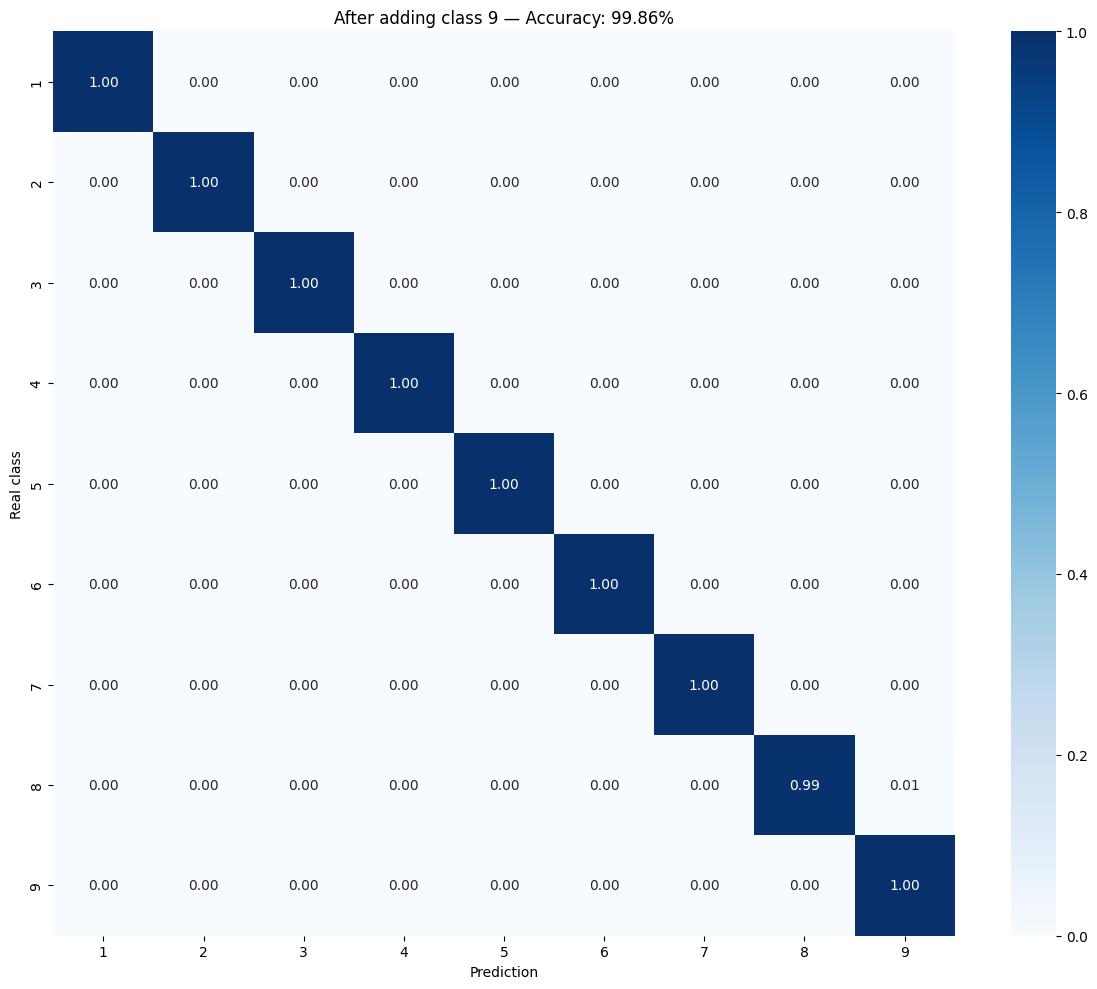

In [7]:
# + CLASS 9
mask_9 = y_all == 9
X_9 = X_all[mask_9]
y_9 = y_all[mask_9]

X_9_train, X_9_test, y_9_train, y_9_test = train_test_split(
    X_9, y_9, test_size=0.2, stratify=y_9, random_state=42
)


X_test_all = np.vstack([X_test_all, X_9_test])
y_test_all = np.hstack([y_test_all, y_9_test])

# SV Transfer
X_sv = current_X[current_expert.support_]
y_sv = current_y[current_expert.support_]

X_9_train_sc = scaler.transform(X_9_train)
X_next = np.vstack([X_sv, X_9_train_sc])
y_next = np.hstack([y_sv, y_9_train])

current_expert = SVC(C=C1, gamma=gamma1, kernel='rbf',
                     class_weight='balanced', probability=True, random_state=42)
current_expert.fit(X_next, y_next)
current_X = X_next
current_y = y_next

acc = accuracy_score(y_next, current_expert.predict(X_next))
print(f"Classes: {sorted(np.unique(y_next))} | Train: {acc:.4f} | SVs: {len(current_expert.support_)}")

# Test
X_test_all_sc = scaler.transform(X_test_all)
y_pred = current_expert.predict(X_test_all_sc)
acc_test = accuracy_score(y_test_all, y_pred)
print(f"Test accuracy: {acc_test:.4f}")

# Confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
labels = np.array(sorted(np.unique(current_y)))
cm = confusion_matrix(y_test_all, y_pred, labels=labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels.astype(int),
            yticklabels=labels.astype(int),
            ax=ax, vmin=0, vmax=1)
ax.set_xlabel('Prediction')
ax.set_ylabel('Real class')
ax.set_title(f"After adding class 9 — Accuracy: {acc_test:.2%}")
plt.tight_layout()
plt.show()

Classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] | Train: 1.0000 | SVs: 1179
Test accuracy: 1.0000


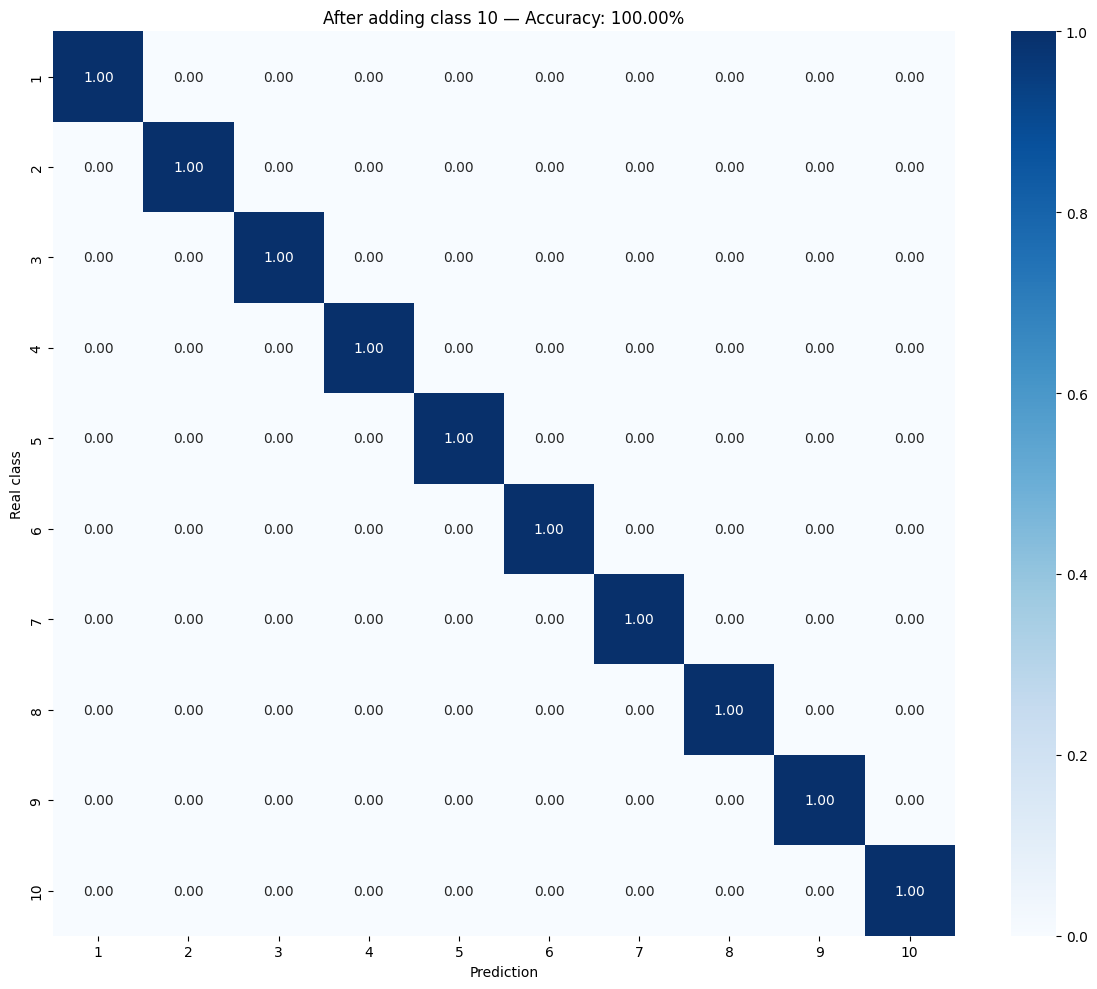

In [8]:
# + CLASSE 10
mask_10 = y_all == 10
X_10 = X_all[mask_10]
y_10 = y_all[mask_10]

X_10_train, X_10_test, y_10_train, y_10_test = train_test_split(
    X_10, y_10, test_size=0.2, stratify=y_10, random_state=42
)

X_test_all = np.vstack([X_test_all, X_10_test])
y_test_all = np.hstack([y_test_all, y_10_test])

# SV Transfer
X_sv = current_X[current_expert.support_]
y_sv = current_y[current_expert.support_]

X_10_train_sc = scaler.transform(X_10_train)
X_next = np.vstack([X_sv, X_10_train_sc])
y_next = np.hstack([y_sv, y_10_train])

current_expert = SVC(C=C1, gamma=gamma1, kernel='rbf',
                     class_weight='balanced', probability=True, random_state=42)
current_expert.fit(X_next, y_next)
current_X = X_next
current_y = y_next

acc = accuracy_score(y_next, current_expert.predict(X_next))
print(f"Classes: {sorted(np.unique(y_next))} | Train: {acc:.4f} | SVs: {len(current_expert.support_)}")

# Test
X_test_all_sc = scaler.transform(X_test_all)
y_pred = current_expert.predict(X_test_all_sc)
acc_test = accuracy_score(y_test_all, y_pred)
print(f"Test accuracy: {acc_test:.4f}")

# Confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
labels = np.array(sorted(np.unique(current_y)))
cm = confusion_matrix(y_test_all, y_pred, labels=labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels.astype(int),
            yticklabels=labels.astype(int),
            ax=ax, vmin=0, vmax=1)
ax.set_xlabel('Prediction')
ax.set_ylabel('Real class')
ax.set_title(f"After adding class 10 — Accuracy: {acc_test:.2%}")
plt.tight_layout()
plt.show()

Classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)] | Train: 0.9766 | SVs: 1271
Test accuracy: 0.9890


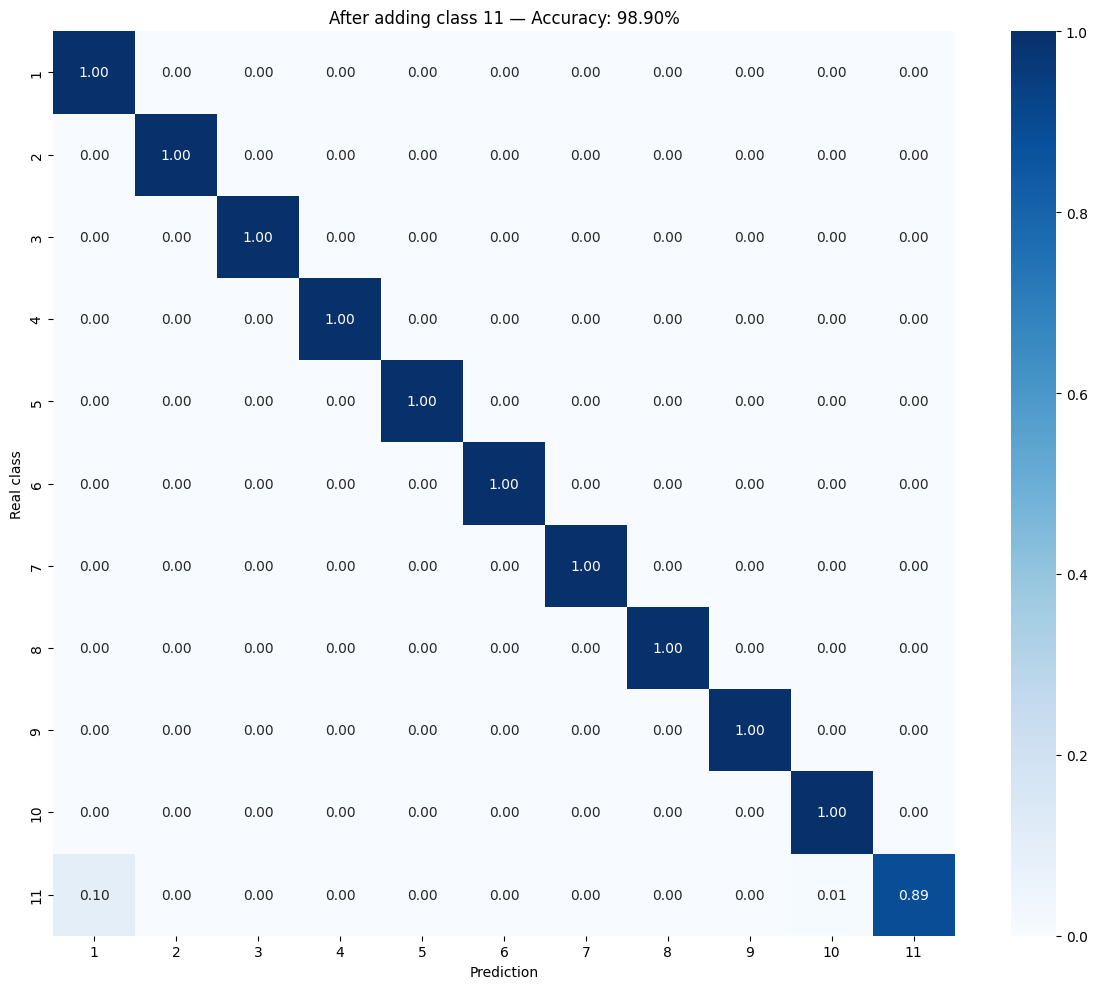

In [9]:
# + CLASSE 11
mask_11 = y_all == 11
X_11 = X_all[mask_11]
y_11 = y_all[mask_11]

X_11_train, X_11_test, y_11_train, y_11_test = train_test_split(
    X_11, y_11, test_size=0.2, stratify=y_11, random_state=42
)

X_test_all = np.vstack([X_test_all, X_11_test])
y_test_all = np.hstack([y_test_all, y_11_test])

# SV Transfer
X_sv = current_X[current_expert.support_]
y_sv = current_y[current_expert.support_]

X_11_train_sc = scaler.transform(X_11_train)
X_next = np.vstack([X_sv, X_11_train_sc])
y_next = np.hstack([y_sv, y_11_train])

current_expert = SVC(C=C1, gamma=gamma1, kernel='rbf',
                     class_weight='balanced', probability=True, random_state=42)
current_expert.fit(X_next, y_next)
current_X = X_next
current_y = y_next

acc = accuracy_score(y_next, current_expert.predict(X_next))
print(f"Classes: {sorted(np.unique(y_next))} | Train: {acc:.4f} | SVs: {len(current_expert.support_)}")

# Test
X_test_all_sc = scaler.transform(X_test_all)
y_pred = current_expert.predict(X_test_all_sc)
acc_test = accuracy_score(y_test_all, y_pred)
print(f"Test accuracy: {acc_test:.4f}")

# Confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
labels = np.array(sorted(np.unique(current_y)))
cm = confusion_matrix(y_test_all, y_pred, labels=labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels.astype(int),
            yticklabels=labels.astype(int),
            ax=ax, vmin=0, vmax=1)
ax.set_xlabel('Prediction')
ax.set_ylabel('Real class')
ax.set_title(f"After adding class 11 — Accuracy: {acc_test:.2%}")
plt.tight_layout()
plt.show()

Classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)] | Train: 0.9559 | SVs: 1372
Test accuracy: 0.9790


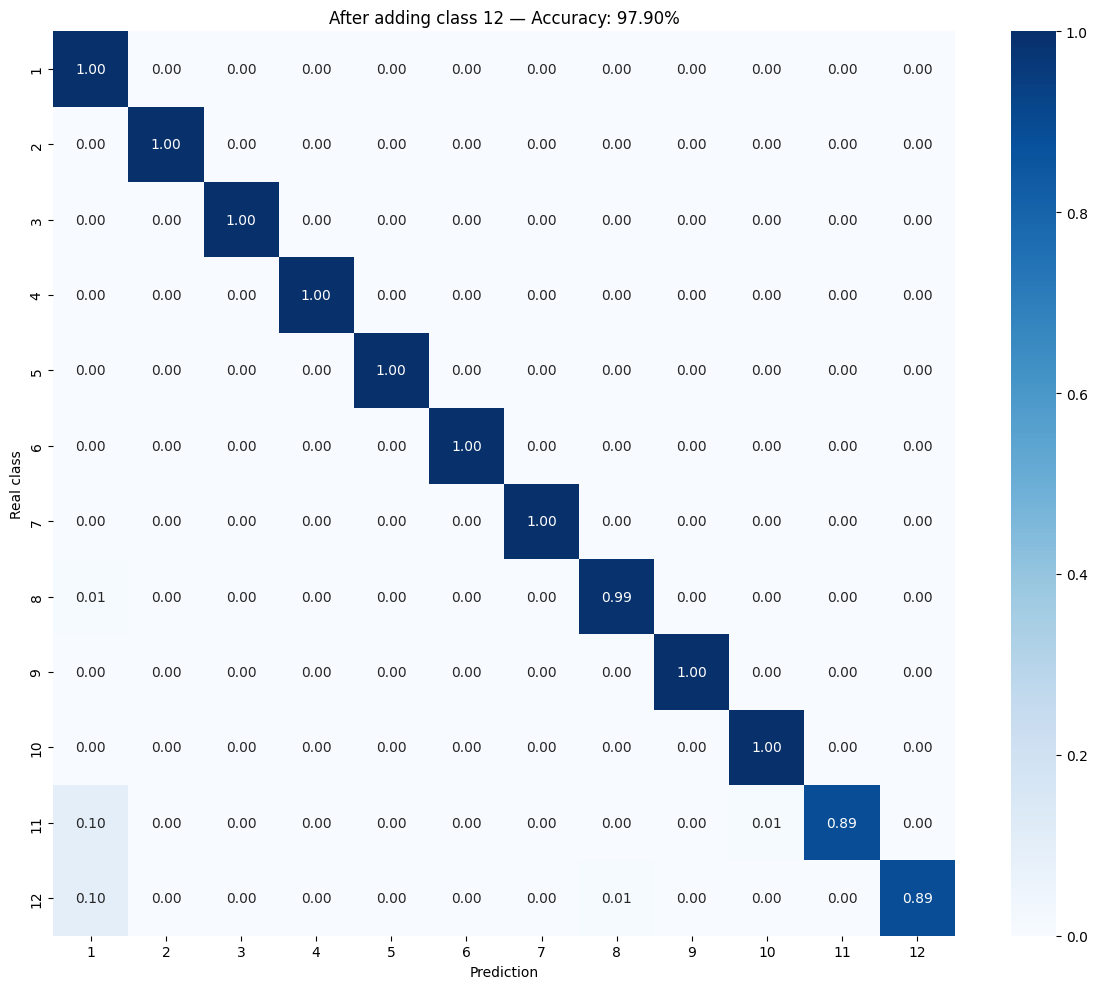

In [10]:
# + CLASSE 12
mask_12 = y_all == 12
X_12 = X_all[mask_12]
y_12 = y_all[mask_12]

X_12_train, X_12_test, y_12_train, y_12_test = train_test_split(
    X_12, y_12, test_size=0.2, stratify=y_12, random_state=42
)

X_test_all = np.vstack([X_test_all, X_12_test])
y_test_all = np.hstack([y_test_all, y_12_test])

# SV Transfer
X_sv = current_X[current_expert.support_]
y_sv = current_y[current_expert.support_]

X_12_train_sc = scaler.transform(X_12_train)
X_next = np.vstack([X_sv, X_12_train_sc])
y_next = np.hstack([y_sv, y_12_train])

current_expert = SVC(C=C1, gamma=gamma1, kernel='rbf',
                     class_weight='balanced', probability=True, random_state=42)
current_expert.fit(X_next, y_next)
current_X = X_next
current_y = y_next

acc = accuracy_score(y_next, current_expert.predict(X_next))
print(f"Classes: {sorted(np.unique(y_next))} | Train: {acc:.4f} | SVs: {len(current_expert.support_)}")

# Test
X_test_all_sc = scaler.transform(X_test_all)
y_pred = current_expert.predict(X_test_all_sc)
acc_test = accuracy_score(y_test_all, y_pred)
print(f"Test accuracy: {acc_test:.4f}")

# Confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
labels = np.array(sorted(np.unique(current_y)))
cm = confusion_matrix(y_test_all, y_pred, labels=labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels.astype(int),
            yticklabels=labels.astype(int),
            ax=ax, vmin=0, vmax=1)
ax.set_xlabel('Prediction')
ax.set_ylabel('Real class')
ax.set_title(f"After adding class 12 — Accuracy: {acc_test:.2%}")
plt.tight_layout()
plt.show()

Classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13)] | Train: 0.9376 | SVs: 1467
Test accuracy: 0.9725


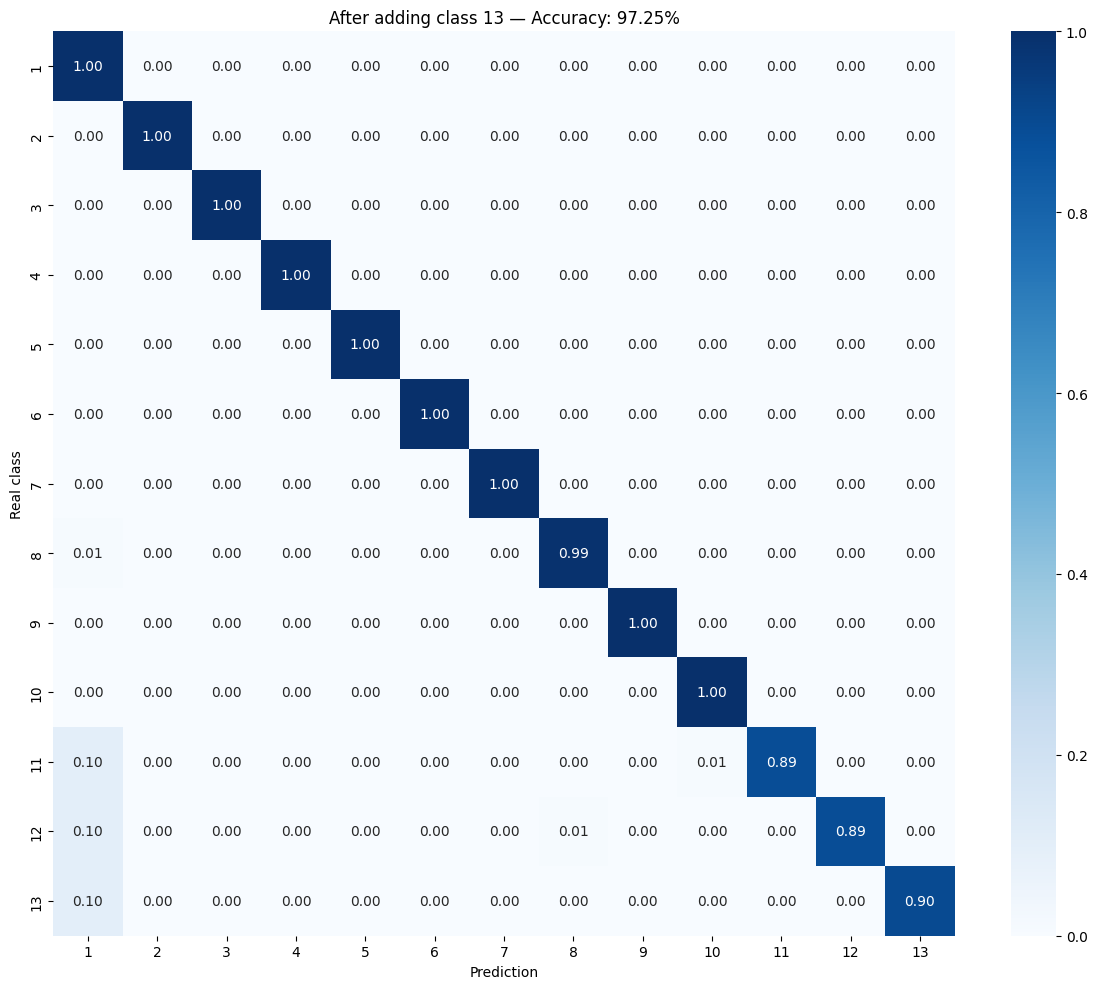

In [11]:
# + CLASSE 13
mask_13 = y_all == 13
X_13 = X_all[mask_13]
y_13 = y_all[mask_13]

X_13_train, X_13_test, y_13_train, y_13_test = train_test_split(
    X_13, y_13, test_size=0.2, stratify=y_13, random_state=42
)

X_test_all = np.vstack([X_test_all, X_13_test])
y_test_all = np.hstack([y_test_all, y_13_test])

# SV Transfer
X_sv = current_X[current_expert.support_]
y_sv = current_y[current_expert.support_]

X_13_train_sc = scaler.transform(X_13_train)
X_next = np.vstack([X_sv, X_13_train_sc])
y_next = np.hstack([y_sv, y_13_train])

current_expert = SVC(C=C1, gamma=gamma1, kernel='rbf',
                     class_weight='balanced', probability=True, random_state=42)
current_expert.fit(X_next, y_next)
current_X = X_next
current_y = y_next

acc = accuracy_score(y_next, current_expert.predict(X_next))
print(f"Classes: {sorted(np.unique(y_next))} | Train: {acc:.4f} | SVs: {len(current_expert.support_)}")

# Test
X_test_all_sc = scaler.transform(X_test_all)
y_pred = current_expert.predict(X_test_all_sc)
acc_test = accuracy_score(y_test_all, y_pred)
print(f"Test accuracy: {acc_test:.4f}")

# Confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
labels = np.array(sorted(np.unique(current_y)))
cm = confusion_matrix(y_test_all, y_pred, labels=labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels.astype(int),
            yticklabels=labels.astype(int),
            ax=ax, vmin=0, vmax=1)
ax.set_xlabel('Prediction')
ax.set_ylabel('Real class')
ax.set_title(f"After adding class 13 — Accuracy: {acc_test:.2%}")
plt.tight_layout()
plt.show()

Classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14)] | Train: 0.9365 | SVs: 1616
Test accuracy: 0.9729


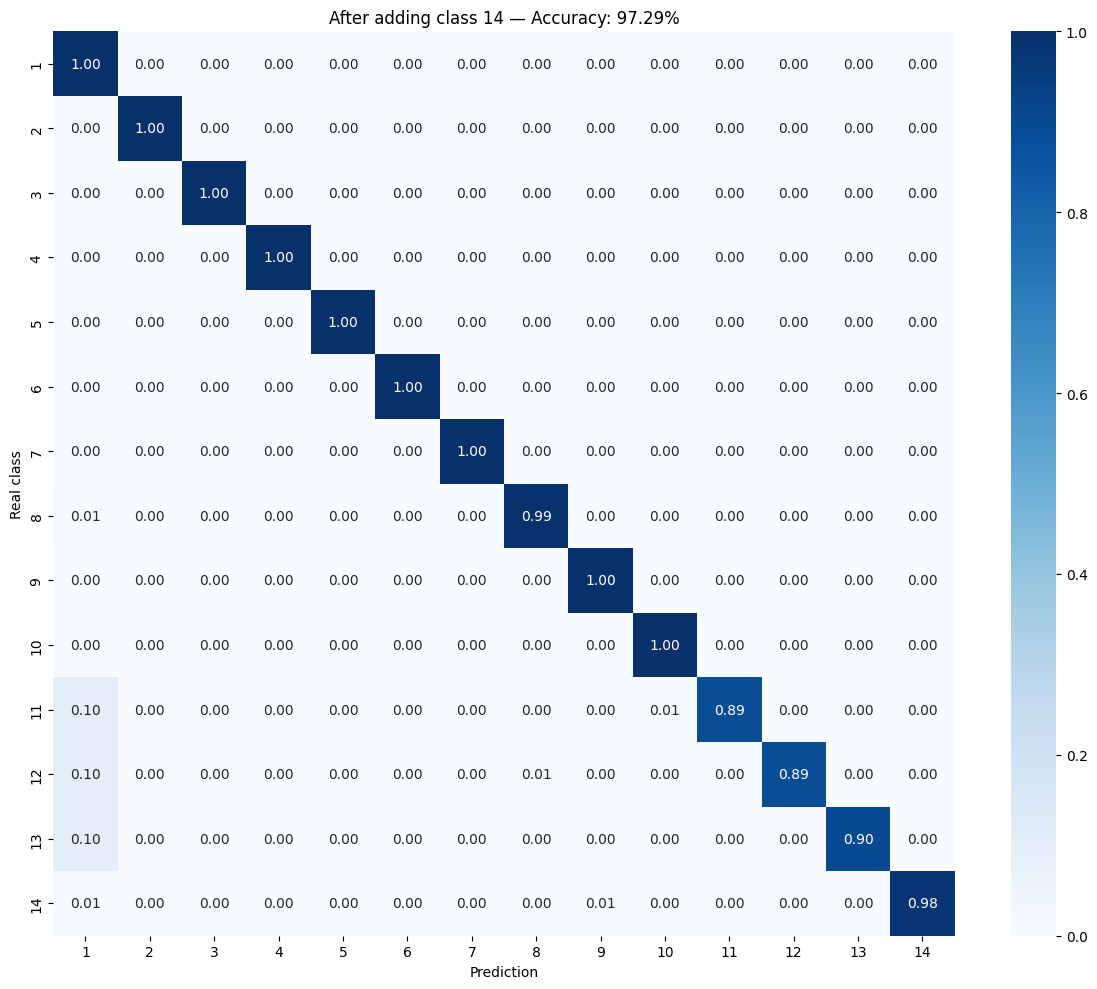

In [12]:
# + CLASSE 14
mask_14 = y_all == 14
X_14 = X_all[mask_14]
y_14 = y_all[mask_14]

X_14_train, X_14_test, y_14_train, y_14_test = train_test_split(
    X_14, y_14, test_size=0.2, stratify=y_14, random_state=42
)

X_test_all = np.vstack([X_test_all, X_14_test])
y_test_all = np.hstack([y_test_all, y_14_test])

# SV Transfer
X_sv = current_X[current_expert.support_]
y_sv = current_y[current_expert.support_]

X_14_train_sc = scaler.transform(X_14_train)
X_next = np.vstack([X_sv, X_14_train_sc])
y_next = np.hstack([y_sv, y_14_train])

current_expert = SVC(C=C1, gamma=gamma1, kernel='rbf',
                     class_weight='balanced', probability=True, random_state=42)
current_expert.fit(X_next, y_next)
current_X = X_next
current_y = y_next

acc = accuracy_score(y_next, current_expert.predict(X_next))
print(f"Classes: {sorted(np.unique(y_next))} | Train: {acc:.4f} | SVs: {len(current_expert.support_)}")

# Test
X_test_all_sc = scaler.transform(X_test_all)
y_pred = current_expert.predict(X_test_all_sc)
acc_test = accuracy_score(y_test_all, y_pred)
print(f"Test accuracy: {acc_test:.4f}")

# Confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
labels = np.array(sorted(np.unique(current_y)))
cm = confusion_matrix(y_test_all, y_pred, labels=labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels.astype(int),
            yticklabels=labels.astype(int),
            ax=ax, vmin=0, vmax=1)
ax.set_xlabel('Prediction')
ax.set_ylabel('Real class')
ax.set_title(f"After adding class 14 — Accuracy: {acc_test:.2%}")
plt.tight_layout()
plt.show()

Classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15)] | Train: 0.9383 | SVs: 1766
Test accuracy: 0.9732


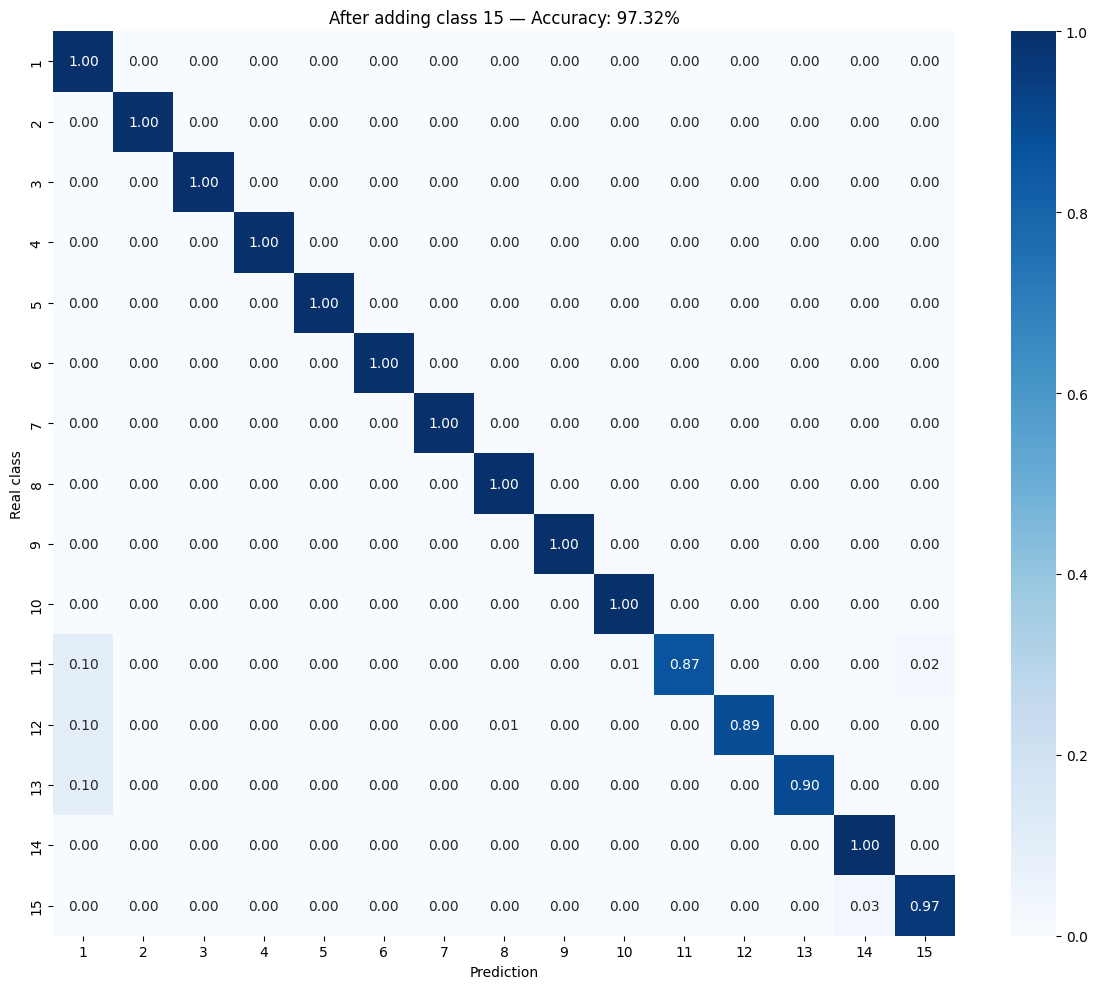

In [13]:
# + CLASSE 15
mask_15 = y_all == 15
X_15 = X_all[mask_15]
y_15 = y_all[mask_15]

X_15_train, X_15_test, y_15_train, y_15_test = train_test_split(
    X_15, y_15, test_size=0.2, stratify=y_15, random_state=42
)

X_test_all = np.vstack([X_test_all, X_15_test])
y_test_all = np.hstack([y_test_all, y_15_test])

# SV Transfer
X_sv = current_X[current_expert.support_]
y_sv = current_y[current_expert.support_]

X_15_train_sc = scaler.transform(X_15_train)
X_next = np.vstack([X_sv, X_15_train_sc])
y_next = np.hstack([y_sv, y_15_train])

current_expert = SVC(C=C1, gamma=gamma1, kernel='rbf',
                     class_weight='balanced', probability=True, random_state=42)
current_expert.fit(X_next, y_next)
current_X = X_next
current_y = y_next

acc = accuracy_score(y_next, current_expert.predict(X_next))
print(f"Classes: {sorted(np.unique(y_next))} | Train: {acc:.4f} | SVs: {len(current_expert.support_)}")

# Test
X_test_all_sc = scaler.transform(X_test_all)
y_pred = current_expert.predict(X_test_all_sc)
acc_test = accuracy_score(y_test_all, y_pred)
print(f"Test accuracy: {acc_test:.4f}")

# Confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
labels = np.array(sorted(np.unique(current_y)))
cm = confusion_matrix(y_test_all, y_pred, labels=labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels.astype(int),
            yticklabels=labels.astype(int),
            ax=ax, vmin=0, vmax=1)
ax.set_xlabel('Prediction')
ax.set_ylabel('Real class')
ax.set_title(f"After adding class 15 — Accuracy: {acc_test:.2%}")
plt.tight_layout()
plt.show()

Classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16)] | Train: 0.9384 | SVs: 1915
Test accuracy: 0.9713


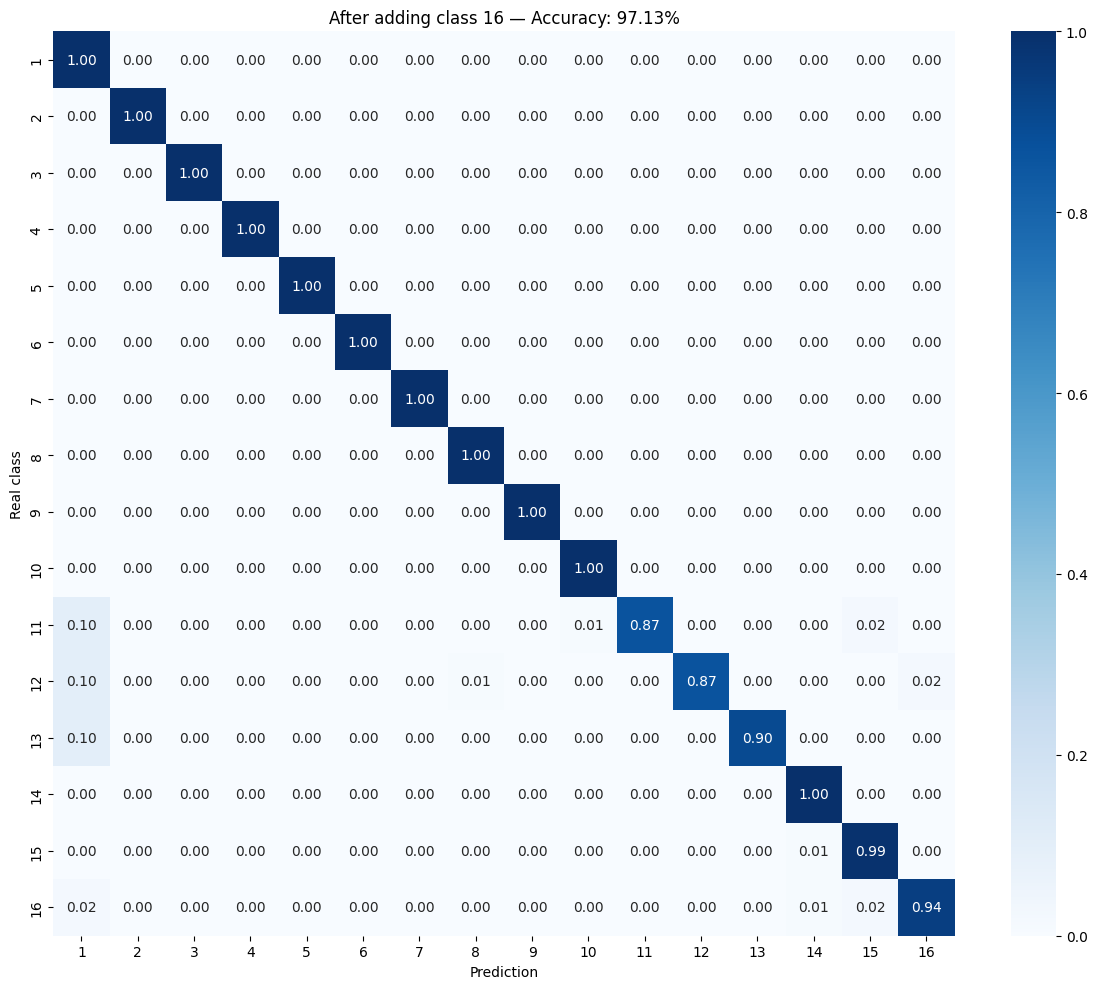

In [14]:
# + CLASSE 16
mask_16 = y_all == 16
X_16 = X_all[mask_16]
y_16 = y_all[mask_16]

X_16_train, X_16_test, y_16_train, y_16_test = train_test_split(
    X_16, y_16, test_size=0.2, stratify=y_16, random_state=42
)

X_test_all = np.vstack([X_test_all, X_16_test])
y_test_all = np.hstack([y_test_all, y_16_test])

# SV Transfer
X_sv = current_X[current_expert.support_]
y_sv = current_y[current_expert.support_]

X_16_train_sc = scaler.transform(X_16_train)
X_next = np.vstack([X_sv, X_16_train_sc])
y_next = np.hstack([y_sv, y_16_train])

current_expert = SVC(C=C1, gamma=gamma1, kernel='rbf',
                     class_weight='balanced', probability=True, random_state=42)
current_expert.fit(X_next, y_next)
current_X = X_next
current_y = y_next

acc = accuracy_score(y_next, current_expert.predict(X_next))
print(f"Classes: {sorted(np.unique(y_next))} | Train: {acc:.4f} | SVs: {len(current_expert.support_)}")

# Test
X_test_all_sc = scaler.transform(X_test_all)
y_pred = current_expert.predict(X_test_all_sc)
acc_test = accuracy_score(y_test_all, y_pred)
print(f"Test accuracy: {acc_test:.4f}")

# Confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
labels = np.array(sorted(np.unique(current_y)))
cm = confusion_matrix(y_test_all, y_pred, labels=labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels.astype(int),
            yticklabels=labels.astype(int),
            ax=ax, vmin=0, vmax=1)
ax.set_xlabel('Prediction')
ax.set_ylabel('Real class')
ax.set_title(f"After adding class 16 — Accuracy: {acc_test:.2%}")
plt.tight_layout()
plt.show()

In [16]:
#add new fault to improve existing svm
uploaded = files.upload()
file2 = list(uploaded.keys())[0]
df2 = pd.read_csv(file2)
X_file2 = df2[FEATURE_COLS].values
y_file2 = df2[LABEL_COL].values

X_file2_sc = scaler.transform(X_file2)
print(f"File : {len(y_file2)} samples, classes {sorted(np.unique(y_file2))}")

Saving data_exp9.csv to data_exp9.csv
Fichier 2: 5305 samples, classes [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16)]


In [17]:
# SVs de l'expert actuel
X_sv = current_X[current_expert.support_]
y_sv = current_y[current_expert.support_]

# Union
X_e3_data = np.vstack([X_sv, X_file2_sc])
y_e3_data = np.hstack([y_sv, y_file2])

print(f"SVs: {len(y_sv)} + Fichier2: {len(y_file2)} = {len(y_e3_data)} total")

SVs: 1915 + Fichier2: 5305 = 7220 total


In [18]:
C3, gamma3 = optimize_svm(X_e3_data, y_e3_data, n_trials=50, name="E3 raffinement")

expert3 = SVC(C=C3, gamma=gamma3, kernel='rbf',
              class_weight='balanced', probability=True, random_state=42)
expert3.fit(X_e3_data, y_e3_data)

acc3_train = accuracy_score(y_e3_data, expert3.predict(X_e3_data))
n_sv3 = len(expert3.support_)

print(f"\nEXPERT 3 (raffinement)")
print(f"  C={C3:.4f}, gamma={gamma3:.6f}")
print(f"  Accuracy (train): {acc3_train:.4f}")
print(f"  Support Vectors:  {n_sv3}")
print(f"  Classes:          {sorted(np.unique(y_e3_data))}")

[I 2026-02-25 18:34:22,048] A new study created in memory with name: no-name-ba44512f-321c-400f-b8d6-fe67f0fd5b91


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-25 18:34:29,860] Trial 0 finished with value: 0.8554021169667347 and parameters: {'C': 7.4593432857265505, 'gamma': 5.669849511478847}. Best is trial 0 with value: 0.8554021169667347.
[I 2026-02-25 18:34:32,277] Trial 1 finished with value: 0.8772848725713759 and parameters: {'C': 457.0563099801454, 'gamma': 0.09846738873614563}. Best is trial 1 with value: 0.8772848725713759.
[I 2026-02-25 18:34:40,412] Trial 2 finished with value: 0.11939332990516831 and parameters: {'C': 0.6026889128682511, 'gamma': 0.000602521573620386}. Best is trial 1 with value: 0.8772848725713759.
[I 2026-02-25 18:34:48,328] Trial 3 finished with value: 0.6722997127962073 and parameters: {'C': 0.195172246414495, 'gamma': 2.1423021757741068}. Best is trial 1 with value: 0.8772848725713759.
[I 2026-02-25 18:34:51,110] Trial 4 finished with value: 0.8771470782951222 and parameters: {'C': 101.29197956845728, 'gamma': 0.3470266988650412}. Best is trial 1 with value: 0.8772848725713759.
[I 2026-02-25 18:35


  Test accuracy (E3 raffinement): 0.9765


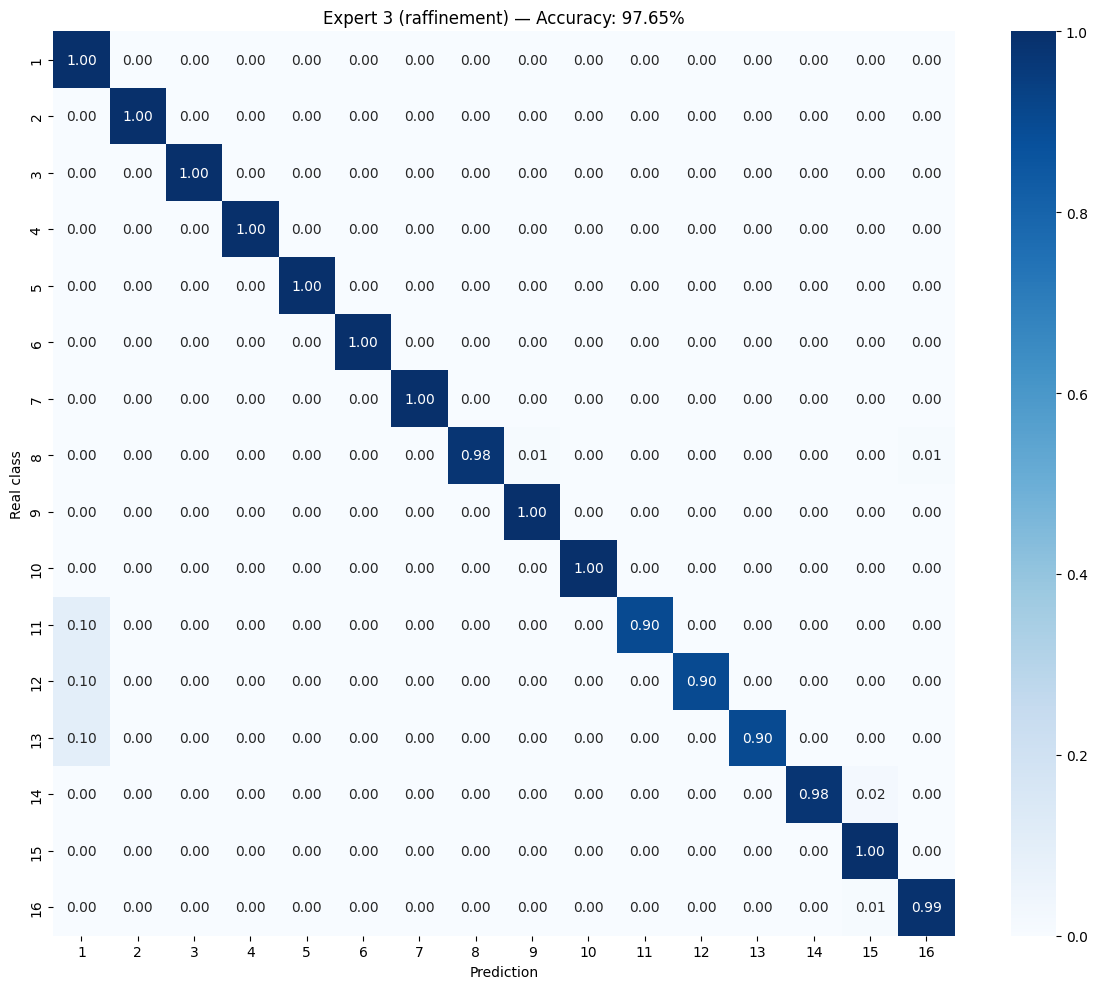

In [19]:
X_test_all_sc = scaler.transform(X_test_all)
y_pred_e3 = expert3.predict(X_test_all_sc)
acc_e3 = accuracy_score(y_test_all, y_pred_e3)
print(f"\n  Test accuracy (E3 raffinement): {acc_e3:.4f}")

fig, ax = plt.subplots(figsize=(12, 10))
labels = np.array(sorted(np.unique(y_e3_data)))
cm = confusion_matrix(y_test_all, y_pred_e3, labels=labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels.astype(int),
            yticklabels=labels.astype(int),
            ax=ax, vmin=0, vmax=1)
ax.set_xlabel('Prediction')
ax.set_ylabel('Real class')
ax.set_title(f"Expert 3 (raffinement) — Accuracy: {acc_e3:.2%}")
plt.tight_layout()
plt.show()

## Sauvegarde

In [ ]:
best_model = {
    'clf': expert3,
    'scaler': scaler,
    'classes': sorted(np.unique(y_e3_data).tolist()),
    'accuracy_train': acc3_train,
    'accuracy_test': acc_e3,
    'C': C3,
    'gamma': gamma3,
    'method': 'SV Transfer (1 par 1 + raffinement)',
    'n_sv': n_sv3,
}

with open('learnpp_sv_transfer.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"Sauvegardé: learnpp_sv_transfer.pkl")
print(f"  Classes: {best_model['classes']}")
print(f"  Test accuracy: {acc_e3:.4f}")
files.download('learnpp_sv_transfer.pkl')